In [1]:
require 'cudnn'
require 'inn'
require 'image'
require 'dcnn'

-- Loads the mapping from net outputs to human readable labels
function load_synset()
  local file = io.open 'synset_words.txt'
  local list = {}
  while true do
    local line = file:read()
    if not line then break end
    table.insert(list, string.sub(line,11))
  end
  return list
end

-- Converts an image from RGB to BGR format and subtracts mean
function preprocess(im, img_mean)
  -- rescale the image
  local im3 = image.scale(im,224,224,'bilinear')*255
  -- RGB2BGR
  local im4 = im3:clone()
  im4[{1,{},{}}] = im3[{3,{},{}}]
  im4[{3,{},{}}] = im3[{1,{},{}}]

  -- subtract imagenet mean
  return im4 - image.scale(img_mean, 224, 224, 'bilinear')
end

-- Setting up networks 
print '==> Loading network'

--net = torch.load('/home/yusheng/Workspace/DeepLearning/models/zeilerNet/zeilerNet.net')
net = torch.load('/usr/local/data/zeilerNet/zeilerNet.net')
net:cuda()
-- as we want to classify, let's disable dropouts by enabling evaluation mode
net:evaluate()

print '==> Loading synsets'
synset_words = load_synset()

print '==> Loading image and imagenet mean'
image_name = 'Goldfish3.jpg'
--image_name = 'lena.jpg'
--image_name='people2.jpg'
img_mean_name = 'ilsvrc_2012_mean.t7'

im = image.load(image_name)
img_mean = torch.load(img_mean_name).img_mean:transpose(3,1)

-- Have to resize and convert from RGB to BGR and subtract mean
print '==> Preprocessing'
I = preprocess(im, img_mean)

-- Replace pooling by dual pooling
unpooling_layers = dcnn:ReplaceDualPoolingModule(net:get(1))

_,classes = net:forward(I:cuda()):view(-1):float():sort(true)

for i=1,5 do
  print('predicted class '..tostring(i)..': ', synset_words[classes[i] ])
end

==> Loading network	


==> Loading synsets	


==> Loading image and imagenet mean	


==> Preprocessing	


predicted class 1: 	goldfish, Carassius auratus	
predicted class 2: 	macaw	
predicted class 3: 	flamingo	
predicted class 4: 	axolotl, mud puppy, Ambystoma mexicanum	
predicted class 5: 	eft	


In [2]:
function dcnn:CreateDeconvNet( net, unpooling_layers, input_img, layer_num, neuron_index, normal_deconv  )
    neuron_index = neuron_index or 0
    if neuron_index == true then
        neuron_index = 0 
        normal_deconv = true
    end
    
    if neuron_index == false then
        neuron_index = 0 
        normal_deconv = false
    end 
    
    local deconvNet = nn.Sequential()
    local first_deconv = true
    for i=layer_num,1,-1 do
        if torch.typename( net:get(i)) == 'cudnn.SpatialConvolution' then
            local reconstructed_size = 0
            if i==1 then
                reconstructed_size = input_img:size(2)
            else    
                reconstructed_size = net:get(i-1).output:size(2)
            end
                
            if first_deconv == true then
                --print( net:get(i) )
                if neuron_index ~= 0 then 
                    deconvNet:add( cudnn.SpatialDeconvolution( net:get(i), reconstructed_size, neuron_index ))
                    --print(neuron_index)
                else
                    deconvNet:add( cudnn.SpatialDeconvolution( net:get(i), reconstructed_size, normal_deconv ))
                end
                
                first_deconv = false
            else
                deconvNet:add( cudnn.SpatialDeconvolution( net:get(i), reconstructed_size, true ))
            end
            
        elseif torch.typename( net:get(i)) == 'dcnn.DualSpatialMaxPooling' then
            local unpooling_idx = 1
            for j=i,1,-1 do  
                if j-1 > 1 and torch.typename( net:get(j-1)) == 'dcnn.DualSpatialMaxPooling' then
                   unpooling_idx = unpooling_idx + 1
                end
            end
            
            deconvNet:add( unpooling_layers[unpooling_idx])
            
        elseif torch.typename( net:get(i)) == 'cudnn.ReLU' then
            deconvNet:add( cudnn.ReLU(true) )
            
        else
            print( torch.typename( net:get(i))..' This type of layer is not supported !')
        end
        
        --print('Layer '..i..' is complete ')
    end    
        
    --deconvNet:cuda()
    return deconvNet
end

cudnn.SpatialConvolution(384 -> 256, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(384 -> 384, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(256 -> 384, 3x3, 1,1, 1,1)	
deconv layer has been built !	
inn.SpatialSameResponseNormalization This type of layer is not supported !	


cudnn.SpatialConvolution(96 -> 256, 5x5, 2,2)	
deconv layer has been built !	
inn.SpatialSameResponseNormalization This type of layer is not supported !	


cudnn.SpatialConvolution(3 -> 96, 7x7, 2,2, 1,1)	
deconv layer has been built !	


==> Time elapsed: 0.15840101242065 seconds	


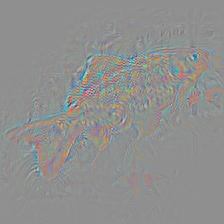

In [3]:
deconvNet_test2 = dcnn:CreateDeconvNet( net:get(1), unpooling_layers, I, 13, 153 )
deconv_timer3 = torch.Timer()
vis_c5_test2 = deconvNet_test2:forward(net:get(1):get(13).output)

print('==> Time elapsed: ' .. deconv_timer3:time().real .. ' seconds')
itorch.image(vis_c5_test2 )


cudnn.SpatialConvolution(384 -> 256, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(384 -> 384, 3x3, 1,1, 1,1)	
deconv layer has been built !	


cudnn.SpatialConvolution(256 -> 384, 3x3, 1,1, 1,1)	
deconv layer has been built !	
inn.SpatialSameResponseNormalization This type of layer is not supported !	


cudnn.SpatialConvolution(96 -> 256, 5x5, 2,2)	
deconv layer has been built !	
inn.SpatialSameResponseNormalization This type of layer is not supported !	


cudnn.SpatialConvolution(3 -> 96, 7x7, 2,2, 1,1)	
deconv layer has been built !	


==> Time elapsed: 0.19624304771423 seconds	


0	


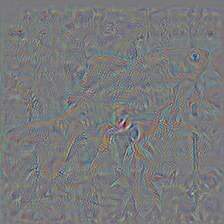

==> Time elapsed: 0.12626194953918 seconds	


0	


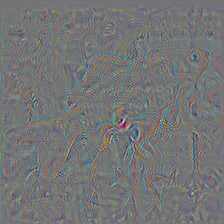

==> Time elapsed: 0.1323070526123 seconds	


0	


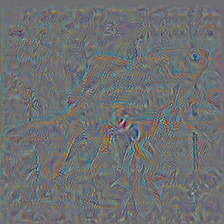

==> Time elapsed: 0.13064408302307 seconds	


0	


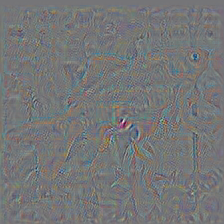

==> Time elapsed: 0.12012982368469 seconds	


0	


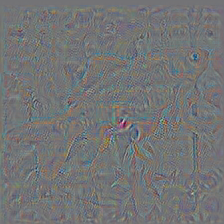

==> Time elapsed: 0.1256730556488 seconds	


0	


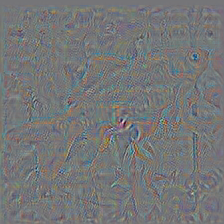

==> Time elapsed: 0.12230777740479 seconds	


0	


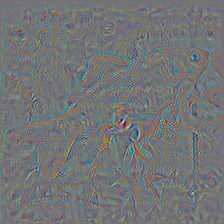

==> Time elapsed: 0.1170608997345 seconds	


0	


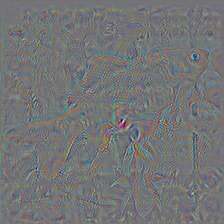

==> Time elapsed: 0.12569093704224 seconds	


0	


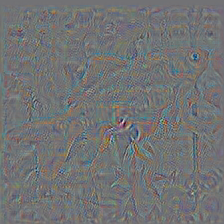

==> Time elapsed: 0.12204909324646 seconds	


0	


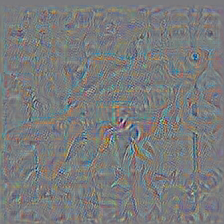

==> Time elapsed: 0.12654399871826 seconds	


0	


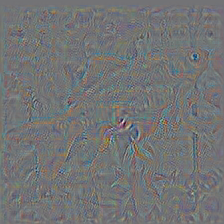

==> Time elapsed: 0.13452887535095 seconds	


0	


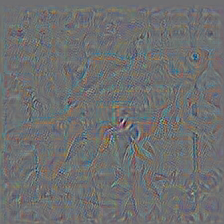

==> Time elapsed: 0.12977313995361 seconds	


0	


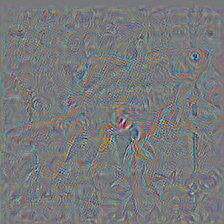

==> Time elapsed: 0.12005186080933 seconds	


0	


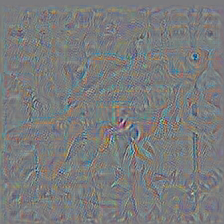

==> Time elapsed: 0.12527680397034 seconds	


0	


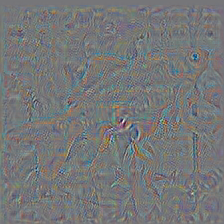

==> Time elapsed: 0.12235593795776 seconds	


0	


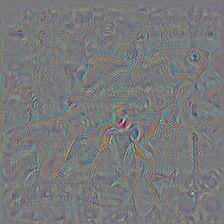

==> Time elapsed: 0.11805200576782 seconds	


0	


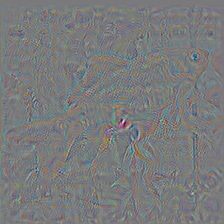

==> Time elapsed: 0.12417101860046 seconds	


0	


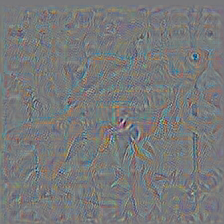

==> Time elapsed: 0.12150597572327 seconds	


0	


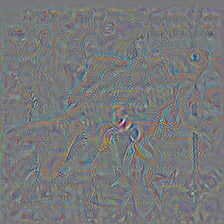

==> Time elapsed: 0.11795616149902 seconds	


0	


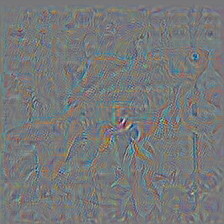

In [4]:
error_tensor = 0
last_output = 0
local last_time = 0
layer_n = 1

deconvNet_test2 = dcnn:CreateDeconvNet( net:get(layer_n), unpooling_layers, I, 13, 27 )
deconv_timer3 = torch.Timer()

for i=1,20 do
    vis_c5_test2 = deconvNet_test2:forward(net:get(1):get(13).output)

    print('==> Time elapsed: ' .. deconv_timer3:time().real-last_time .. ' seconds')    
    --print( deconvNet_test2:get(layer_n).output:size() )
    
    if i==1 then
        last_output = deconvNet_test2:get(layer_n).output
    end
    
    error_tensor = last_output - deconvNet_test2:get(layer_n).output
    local test_error = 0
    for j=1, error_tensor:view(-1):size(1) do
        test_error = test_error + error_tensor:view(-1)[j]
    end
        
    print(test_error)
    --last_output = deconvNet_test2:get(layer_n).output
    --itorch.image( deconvNet_test2:get(1).output )
    itorch.image(vis_c5_test2 )
    last_time = deconv_timer3:time().real
end